# Titanic: Random Forest

In [201]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings(action = 'ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

In [202]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

In [203]:
df = pd.read_excel('Titanic_FullData1.xlsx', usecols=['pclass',    'sex',    'age',    'sibsp',    'parch',    'fare' ,   'survived'])
df.head()

,pclass,sex,age,sibsp,parch,fare,survived
0,1,female,29,0,0,211.3375,1
1,1,male,0.9167,1,2,151.55,1
2,1,female,2,1,2,151.55,0
3,1,male,30,1,2,151.55,0
4,1,female,25,1,2,151.55,0


## Preprocessing
- rename male=>1 and female=>2

In [204]:
df['sex']=df['sex'].replace({'male':1,'female':2})
df.sex.value_counts()

1    843
2    466
Name: sex, dtype: int64

## remove missing entries

In [205]:
print(df.shape)
df = df.replace({'?':np.nan})
df = df.dropna()
print(df.shape)

(1309, 7)
(1045, 7)


In [206]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
features = X.columns.tolist()

In [207]:
print(features)

['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare']


In [208]:
print(X) # X are dependent variables
#print(y) # y is an independent variable

      pclass  sex      age  sibsp  parch      fare
0          1    2  29.0000      0      0  211.3375
1          1    1   0.9167      1      2  151.5500
2          1    2   2.0000      1      2  151.5500
3          1    1  30.0000      1      2  151.5500
4          1    2  25.0000      1      2  151.5500
...      ...  ...      ...    ...    ...       ...
1301       3    1  45.5000      0      0    7.2250
1304       3    2  14.5000      1      0   14.4542
1306       3    1  26.5000      0      0    7.2250
1307       3    1  27.0000      0      0    7.2250
1308       3    1  29.0000      0      0    7.8750

[1045 rows x 6 columns]


{'max_depth': range(3, 500)}
DecisionTreeClassifier(max_depth=5)
[0.18564636 0.55672084 0.1250543  0.05414309 0.         0.07843541]


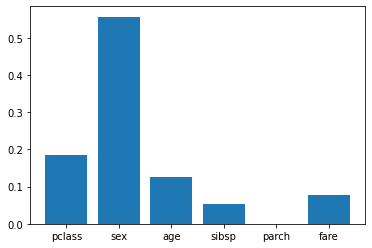

In [209]:
parameters = {'max_depth':range(3,500)}
print(parameters)
Mdls = GridSearchCV(tree.DecisionTreeClassifier(),parameters, n_jobs=4)
Mdls = Mdls.fit(X, y)
Mdl = Mdls.best_estimator_
print(Mdl)
imp = Mdl.feature_importances_

I = np.arange(imp.shape[0])
plt.bar(I,imp)
plt.xticks(I,features);
best_param = Mdl.get_params()
best_param
print(imp)

- We see that gender and class of service were most important.
***
- Now we evaluate the predictive accuracy of the random forests.


In [210]:
pred = Mdl.predict(X)
accuracy = np.mean(pred==y)
accuracy

0.8344497607655502

Lets look at the Confusion Matrix:  the matrix of true and false decisions We see that it is quite accurate for the full sample.

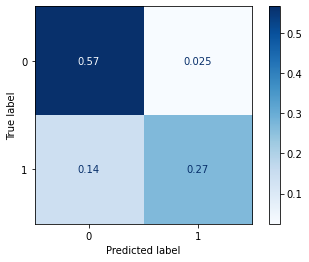

[[0.9150326797385621, 0.19891745602165087],
 [0.08496732026143791, 0.8010825439783491]]

In [211]:
plot_confusion_matrix(Mdl, X, y, normalize = 'all', cmap=plt.cm.Blues)
plt.show()

tn, fp, fn, tp = np.ravel(confusion_matrix(pred,y))
CM = [[tp/(tp+fn), fp/(tn+fp) ],
      [fn/(tp+fn), tn/(tn+fp) ]]
CM

In [212]:
confusion_matrix(pred,y, normalize='true')

array([[0.80108254, 0.19891746],
       [0.08496732, 0.91503268]])

Lets do a repeat set of draws for in an out of sample tests.

In [213]:
def get_sense_rf(times):    
    """test model's accuracies and out of sample possibilities when the number of iterate increases"""
    nexp=times
    test_size = 1- times/y.shape[0]

    false_positives = []
    false_negatives = []
    true_negatives = []
    true_positives = []
    accuracies = []

    clf = tree.DecisionTreeClassifier(**best_param,  )
    for experiment in (range(nexp)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        CM = confusion_matrix(y_test, pred, normalize='true')
    
        false_positives.append(CM[0,1])# it was actually negative class (0-th row in the CM), and falsely predicted positve(1-th column)
        false_negatives.append(CM[1,0])
        true_negatives.append(CM[1,1])
        true_positives.append(CM[0,0])
        accuracies.append(accuracy_score(y_test, pred))
    
    fig, axs = plt.subplots(3, figsize=(10, 12))
    fig.suptitle('Vertically stacked subplots')
    axs[0].hist(false_positives)
    axs[0].set_title('Out-of-Sample False positives')
    axs[0].grid(True)

    axs[1].hist(false_negatives)
    axs[1].set_title('Out-of-Sample False negatives')
    axs[1].grid(True)

    axs[2].hist(accuracies)
    axs[2].set_title('Accuracies')
    axs[2].grid(True)
    
    mean01 = np.mean(false_positives)
    std01 = np.std(false_positives)
    mean10 = np.mean(false_negatives)
    std10 = np.std(false_negatives)
    act_mean = np.mean(accuracies)
    act_std = np.std(accuracies)
    
    return mean01, std01, mean01/std01 , mean10, std10, act_mean, act_std, act_mean/act_std 

(0.112785217911236, 0.04253746771199879, 2.6514323484146196, 0.3559889006944462, 0.04903908907266902, 0.7875706422018349, 0.017373630113322196, 45.33138078022746)


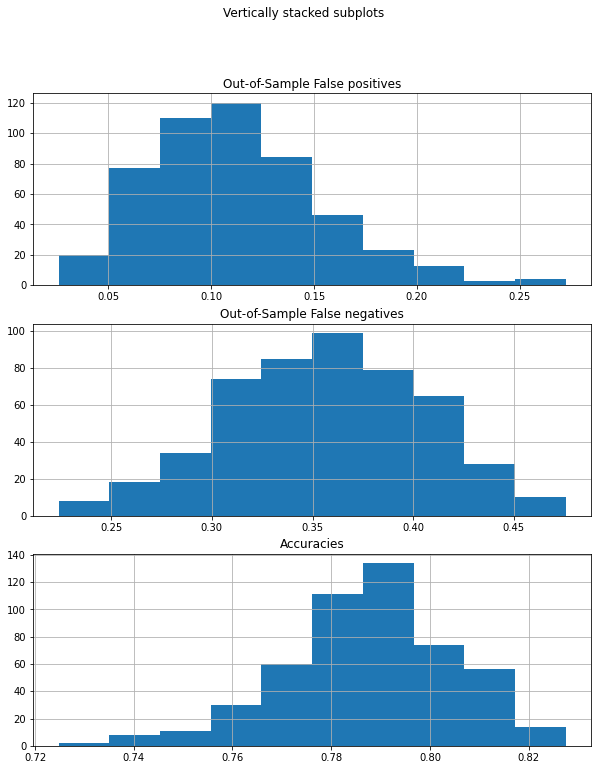

In [214]:
print(get_sense_rf(500))

We see the out of sample predictive accuracy stats, very different.

Sensitivity test to compare the results of models

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rfc = RandomForestClassifier(n_estimators = 10, random_state = 2021)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=2021)

In [216]:
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred = y_pred)
print("The performance of basic model to train set")
print(f"accuracy: {acc:0.4f}")

y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
print("The performance of basic model to test set")
print(f"accuracy: {acc:0.4f}")

The performance of basic model to train set
accuracy: 0.9685
The performance of basic model to test set
accuracy: 0.7675


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


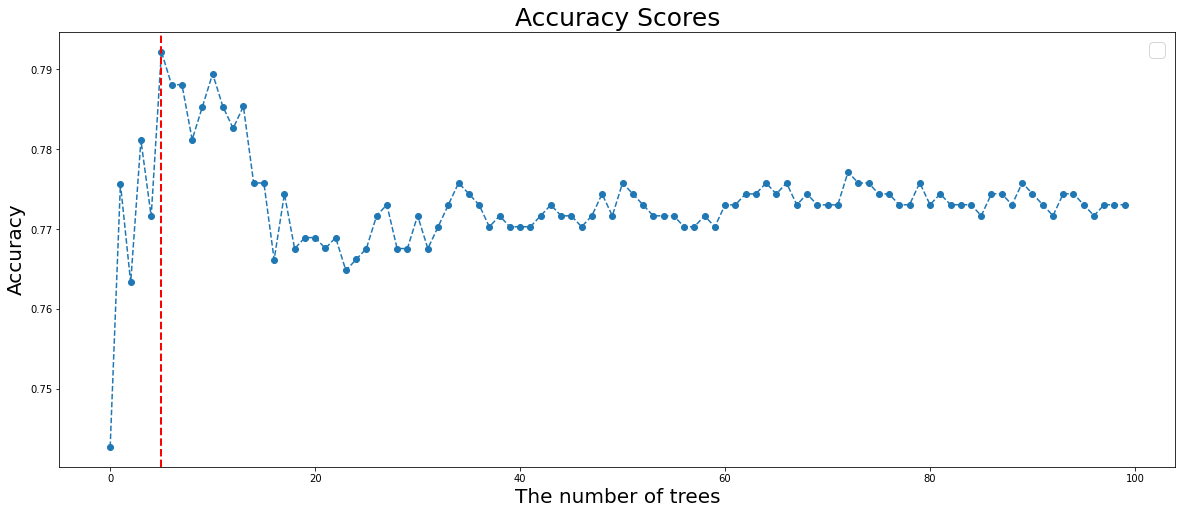

In [217]:
cv_scores = []
estimator_list = [i for i in range(0,100,1)]
for i in tqdm(range(0,100,1)):
    rfc = RandomForestClassifier(n_estimators = i+1,
                                 n_jobs = -1, random_state = 2021)
    score = cross_val_score(rfc, X_train, y_train, cv=10, scoring = 'accuracy').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize = (20,8))
plt.legend(["Cross valid1ation scores"], fontsize = 20)
plt.plot(estimator_list, cv_scores, marker = 'o', linestyle = 'dashed')
plt.xlabel("The number of trees", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy Scores", fontsize = 25)
plt.axvline(best_e[0], color='r', linestyle = '--', linewidth=2)
plt.show()

In [221]:
print(f"the performance is the best when the number of tree is {(cv_scores.index(max(cv_scores)))+1}")
print("The performance(10 fold cross validation)")
print(f"Accuracy: {max(cv_scores): 0.4f}")

the performance is the best when the number of tree is 6
The performance(10 fold cross validation)
Accuracy:  0.7922


In [222]:
rfc = RandomForestClassifier(n_estimators = 65, random_state = 2021)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred = y_pred)
print("The performance of basic model to train set")
print(f"accuracy: {acc:0.4f}")

y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
print("The performance of basic model to test set")
print(f"accuracy: {acc:0.4f}")

The performance of basic model to train set
accuracy: 0.9836
The performance of basic model to test set
accuracy: 0.7707


In [223]:
rfc_score = pd.DataFrame(cv_scores, columns = ['accuracy'])
rfc_score['accu_rank'] = rfc_score['accuracy'].rank(ascending = 0)
rfc_score = rfc_score.sort_values(by=['accu_rank'])
rfc_score.head()

,accuracy,accu_rank
5,0.792207,1.0
10,0.789448,2.0
7,0.788097,3.0
6,0.788041,4.0
13,0.785376,5.0


In [224]:
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators' : [6, 11, 8, 7],
    'max_depth' : [10, 15, 20, 25],
    'max_leaf_nodes' : [25, 30, 35],
    'criterion' : ['gini', 'entropy']
    # 'max_features' : ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv=10, verbose = 1, n_jobs=-1)
CV_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25],
                         'max_leaf_nodes': [25, 30, 35],
                         'n_estimators': [6, 11, 8, 7]},
             verbose=1)

In [225]:
CV_rfc.best_params_

{'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 35, 'n_estimators': 8}

In [226]:
result_table = pd.DataFrame(CV_rfc.cv_results_)
result_table = result_table.sort_values(by = 'mean_test_score', ascending = False)
print(result_table[['params', 'mean_test_score']])

                                               params  mean_test_score
34  {'criterion': 'gini', 'max_depth': 20, 'max_le...         0.816790
25  {'criterion': 'gini', 'max_depth': 20, 'max_le...         0.812662
71  {'criterion': 'entropy', 'max_depth': 15, 'max...         0.812643
41  {'criterion': 'gini', 'max_depth': 25, 'max_le...         0.812643
77  {'criterion': 'entropy', 'max_depth': 20, 'max...         0.812643
..                                                ...              ...
93  {'criterion': 'entropy', 'max_depth': 25, 'max...         0.785320
46  {'criterion': 'gini', 'max_depth': 25, 'max_le...         0.785283
24  {'criterion': 'gini', 'max_depth': 20, 'max_le...         0.783950
50  {'criterion': 'entropy', 'max_depth': 10, 'max...         0.783932
7   {'criterion': 'gini', 'max_depth': 10, 'max_le...         0.777083

[96 rows x 2 columns]


In [227]:
best_rfc = CV_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_leaf_nodes=35, n_estimators=8)

In [228]:
y_pred = best_rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred = y_pred)
print("The performance of the best rfc model to train set")
print(f"accuracy: {acc:0.4f}")

y_pred = best_rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
print("The performance of the best rfc  model to test set")
print(f"accuracy: {acc:0.4f}")

# Accuracy based on total dataset
y_pred = best_rfc.predict(X)
acc = accuracy_score(y_true = y, y_pred = y_pred)
print("The performance of the best rfc model to total data set")
print(f"accuracy: {acc:0.4f}")

The performance of the best rfc model to train set
accuracy: 0.8769
The performance of the best rfc  model to test set
accuracy: 0.8121
The performance of the best rfc model to total data set
accuracy: 0.8574


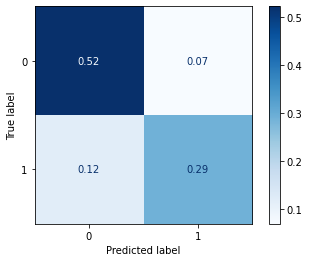

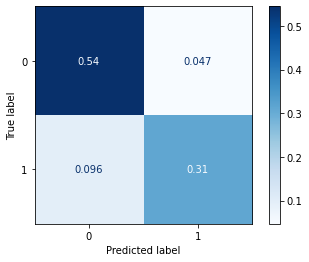

In [229]:
plot_confusion_matrix(best_rfc, X_test, y_test, normalize = 'all', cmap=plt.cm.Blues)
plt.show()
plot_confusion_matrix(best_rfc, X, y, normalize = 'all', cmap=plt.cm.Blues)
plt.show()

[0.10540383 0.37667006 0.17568503 0.06755721 0.06039816 0.21428572]


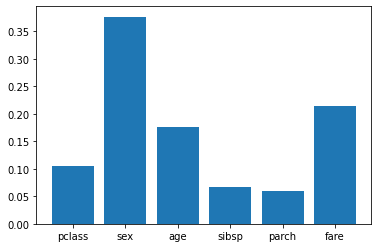

In [230]:
best_imp = best_rfc.feature_importances_

I = np.arange(imp.shape[0])
plt.bar(I,best_imp)
plt.xticks(I,features)
print(best_imp)

$\textbf{Titanic Data: Neural Network Prediction}$

Now lets look at the same data with neural net prediction.
We load in the data and then set up a patternnet neural neet with 31 neurons.
We put in options not to show the intermediate training data in windows.

In [31]:
X_n = MinMaxScaler().fit_transform(X)

In [75]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(7), max_iter=1000).fit(X_n, y)
clf.fit(X_n,y)

pred = clf.predict(X_n) # note, 1 is positive class
accuracy = accuracy_score(y,pred)

CM = confusion_matrix(y, pred, normalize='true')
true_positive = CM[1,1]
true_negative = CM[0,0]
false_positive = CM[0,1]
false_negative = CM[1,0]

accuracy

0.7827751196172249

We have almost an 80 percent accuracy rate, not bad.

Lets simulate the model around the median to get the relative importance.

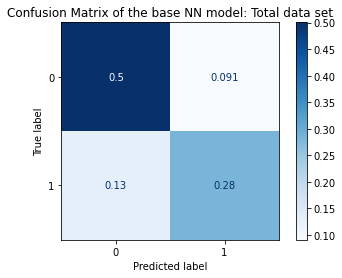

In [76]:
plot_confusion_matrix(clf, X_n, y, normalize = 'all', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of the base NN model: Total data set')
plt.show()

In [77]:
X_median = np.median(X_n, axis=0).reshape((1,-1)) # (1,D)
proba_median = clf.predict_proba(X_median)
proba_median.shape

(1, 2)

In [78]:
proba_median

array([[0.76743376, 0.23256624]])

[0.29738913 0.4386087  0.30909983 0.32725931 0.05877513 0.285952  ]


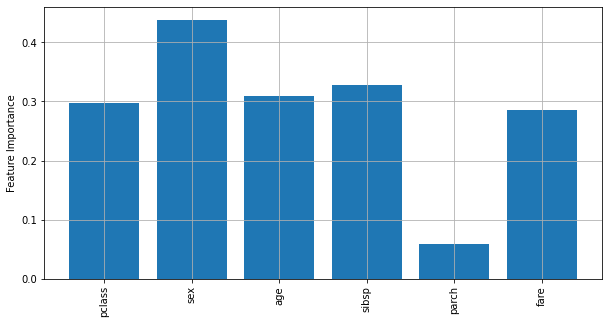

In [79]:
D = X.shape[1]
importance = []
for i in range(D):
    #print(x_median_i_perturbed)
    x_median_i_perturbed = X_median.copy()
    x_median_i_perturbed[0,i]+=0.00001
    
    proba_median_perturbed = clf.predict_proba(x_median_i_perturbed)
    imp = abs(proba_median_perturbed[:,1] - proba_median[:,1])/0.00001 
    importance.append(imp)
importance = np.array(importance).reshape(-1)
    
feature_indices = np.arange(len(importance))

plt.figure(figsize=(10, 5))
plt.bar(feature_indices,importance)
plt.xticks(feature_indices, df.columns[:-1], rotation='vertical')
plt.ylabel('Feature Importance')
plt.grid(True)

print(importance)

We see gender and class are important


Now let's look at out of sample performance of the network.

In [51]:
K = 500
test_size = 1-K/y.shape[0]

false_positives = []
false_negatives = []
accuracies = []

for j in range(100):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size)
    clf = MLPClassifier(random_state=1, hidden_layer_sizes=(7), max_iter=1000).fit(X, y)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    CM = confusion_matrix(y_test, pred, normalize='true')
    
    false_positives.append(CM[0,1])# it was actually negative class (0-th row in the CM), and falsely predicted positve(1-th column)
    false_negatives.append(CM[1,0])
    accuracies.append(accuracy_score(y_test, pred))
    
    

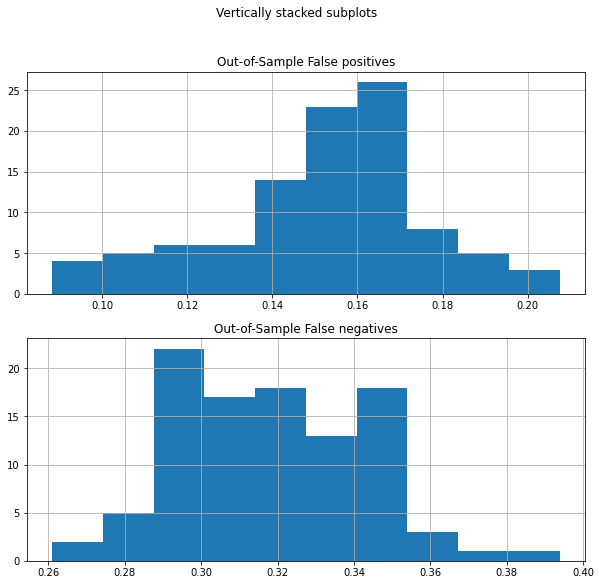

In [52]:
fig, axs = plt.subplots(2, figsize=(10, 9))
fig.suptitle('Vertically stacked subplots')
axs[0].hist(false_positives)
axs[0].set_title('Out-of-Sample False positives')
axs[0].grid(True)

axs[1].hist(false_negatives)
axs[1].set_title('Out-of-Sample False negatives')
axs[1].grid(True)

(array([ 4.,  9., 16., 21., 16.,  5., 12., 10.,  3.,  4.]),
 array([0.7559633 , 0.7612844 , 0.7666055 , 0.77192661, 0.77724771,
        0.78256881, 0.78788991, 0.79321101, 0.79853211, 0.80385321,
        0.80917431]),
 <BarContainer object of 10 artists>)

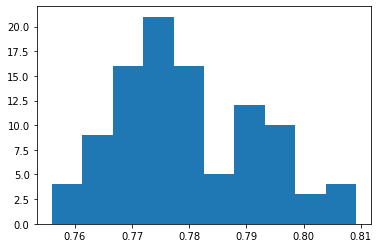

In [53]:
plt.hist(accuracies)

In [35]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y, test_size=0.3)
nn_clf = MLPClassifier(random_state=1, hidden_layer_sizes=(7), max_iter=1000)
nn_clf.fit(X_train_n, y_train_n)

MLPClassifier(hidden_layer_sizes=7, max_iter=1000, random_state=1)

In [39]:
hl_size = [i for i in range(100,151,1)]
max_it = [1000, 2000, 5000, 10000]

100%|██████████| 51/51 [03:45<00:00,  4.42s/it]


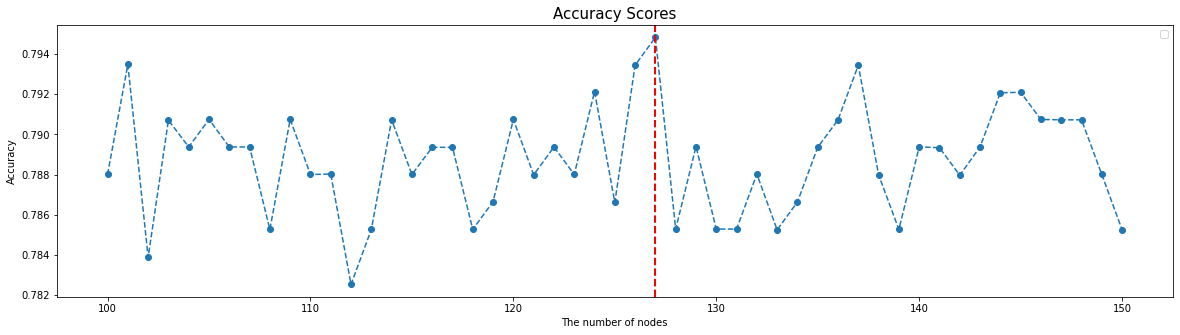

the performance is the best when the number of Hidden Layers is 28
The performance(10 fold cross validation)
Accuracy with Max_it 1000:  0.7948


100%|██████████| 51/51 [03:47<00:00,  4.47s/it]


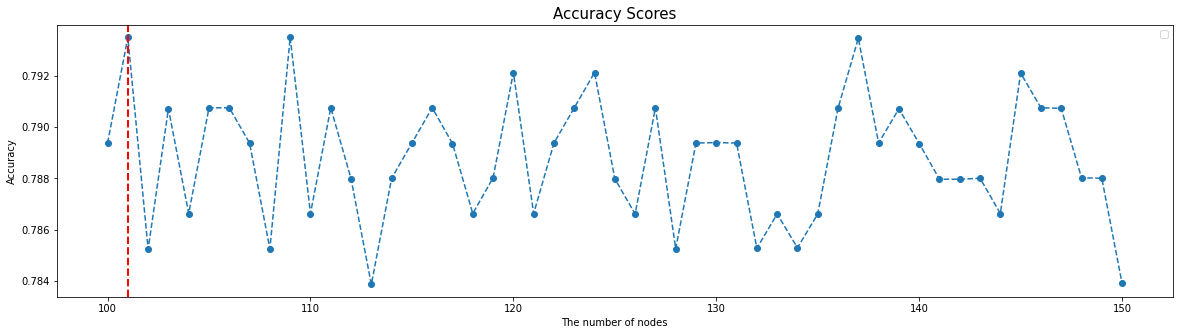

the performance is the best when the number of Hidden Layers is 2
The performance(10 fold cross validation)
Accuracy with Max_it 2000:  0.7935


100%|██████████| 51/51 [03:54<00:00,  4.60s/it]


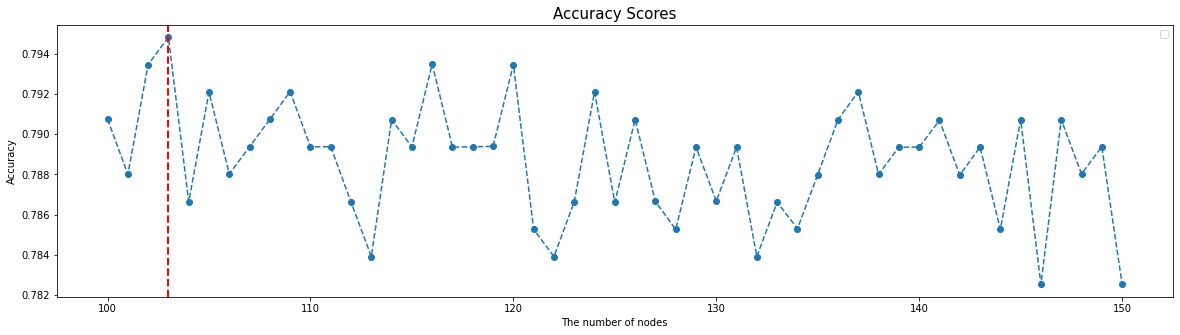

the performance is the best when the number of Hidden Layers is 4
The performance(10 fold cross validation)
Accuracy with Max_it 5000:  0.7948


100%|██████████| 51/51 [04:00<00:00,  4.72s/it]


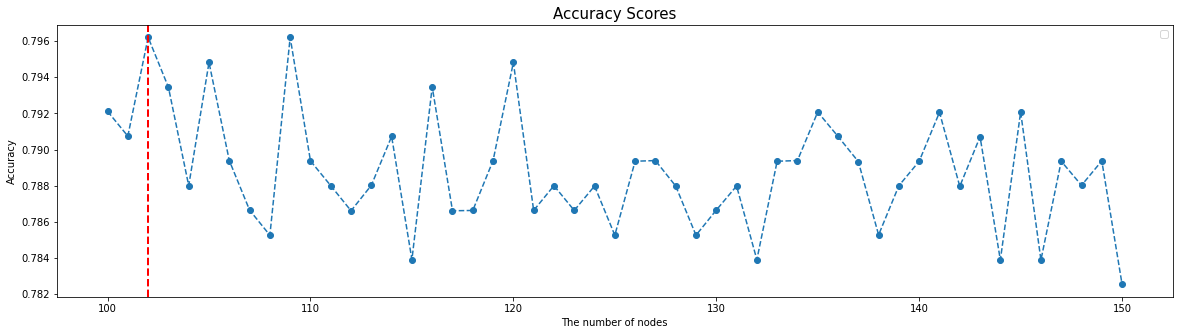

the performance is the best when the number of Hidden Layers is 3
The performance(10 fold cross validation)
Accuracy with Max_it 10000:  0.7962


In [40]:
cv_nn_scores = []

for j in range(0,len(max_it)):
    for i in tqdm(range(0,len(hl_size),1)):
        nn_clf = MLPClassifier(random_state=1, hidden_layer_sizes=hl_size[i], max_iter=hl_size[j]).fit(X_n, y)
        score = cross_val_score(nn_clf, X_train_n, y_train_n, cv=10, scoring = 'accuracy').mean()
        cv_nn_scores.append(score)
        best_e = [hl_size[k] for k in range(len(cv_nn_scores)) if cv_nn_scores[k] == np.max(cv_nn_scores)]
    
    # Show the results
    plt.figure(figsize = (20,5))
    plt.legend(["Cross validation scores"], fontsize = 10)
    plt.plot(hl_size, cv_nn_scores, marker = 'o', linestyle = 'dashed')
    plt.xlabel("The number of nodes", fontsize = 10)
    plt.ylabel("Accuracy", fontsize = 10)
    plt.title("Accuracy Scores", fontsize = 15)
    plt.axvline(best_e[0], color='r', linestyle = '--', linewidth=2)
    plt.show()
    
    # print out how much accurate the results and clean out
    print(f"the performance is the best when the number of Hidden Layers is {(cv_nn_scores.index(max(cv_nn_scores)))+1}")
    print("The performance(10 fold cross validation)")
    print(f"Accuracy with Max_it {max_it[j]}: {max(cv_nn_scores): 0.4f}")
    cv_nn_scores = []

In [42]:
best_nn = MLPClassifier(random_state=1, hidden_layer_sizes=(103), max_iter=10000)
best_nn.fit(X_train_n, y_train_n)

MLPClassifier(hidden_layer_sizes=103, max_iter=10000, random_state=1)

In [57]:
# Accuracy based on Training set
y_pred_n = best_nn.predict(X_train_n)
acc_n = accuracy_score(y_true = y_train_n, y_pred = y_pred_n)
print("The performance of the best NN model to train set")
print(f"accuracy: {acc_n:0.4f}")

# Accuracy based on Test set
y_pred_n = best_nn.predict(X_test_n)
acc_n = accuracy_score(y_true = y_test_n, y_pred = y_pred_n)
print("The performance of the best NN model to test set")
print(f"accuracy: {acc_n:0.4f}")

# Accuracy based on total dataset
y_pred_n = best_nn.predict(X_n)
acc_n = accuracy_score(y_true = y, y_pred = y_pred_n)
print("The performance of the best NN model to total data set")
print(f"accuracy: {acc_n:0.4f}")

The performance of the best NN model to train set
accuracy: 0.8249
The performance of the best NN model to test set
accuracy: 0.8057
The performance of the best NN model to total data set
accuracy: 0.8191


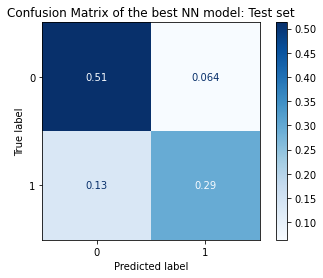

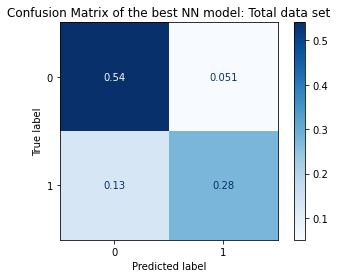

In [233]:
plot_confusion_matrix(best_nn, X_test_n, y_test_n, normalize = 'all', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of the best NN model: Test set')
plt.show()
plot_confusion_matrix(best_nn, X_n, y, normalize = 'all', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of the best NN model: Total data set')
plt.show()

In [82]:
X_median = np.median(X_n, axis=0).reshape((1,-1)) # (1,D)
proba_median = best_nn.predict_proba(X_median)
proba_median.shape

(1, 2)

In [83]:
proba_median

array([[0.86456388, 0.13543612]])

[9712.71441496 9713.45041279 9712.70270427 9712.68454478 9713.07057922
 9713.2977561 ]


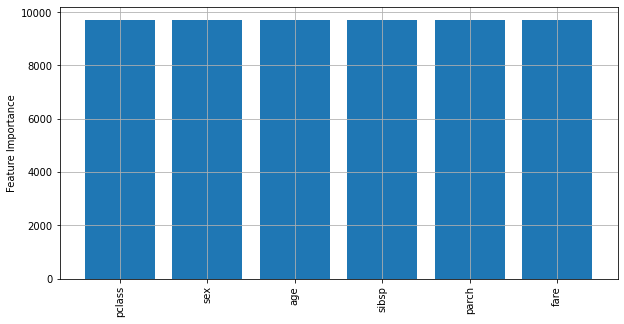

In [84]:
D = X.shape[1]
importance = []
for i in range(D):
    #print(x_median_i_perturbed)
    x_median_i_perturbed = X_median.copy()
    x_median_i_perturbed[0,i]+=0.00001
    
    proba_median_perturbed = clf.predict_proba(x_median_i_perturbed)
    imp = abs(proba_median_perturbed[:,1] - proba_median[:,1])/0.00001 
    importance.append(imp)
importance = np.array(importance).reshape(-1)
    
feature_indices = np.arange(len(importance))

plt.figure(figsize=(10, 5))
plt.bar(feature_indices,importance)
plt.xticks(feature_indices, df.columns[:-1], rotation='vertical')
plt.ylabel('Feature Importance')
plt.grid(True)

print(importance)